In [1]:
# !pip3 uninstall phase3 -y
# !pip3 install git+https://github.com/spapa013/microns_phase3_nda.git

# Introduction to DataJoint

[DataJoint](https://datajoint.io/) is a free, open-source framework for programming scientific databases and computational data pipelines. 

```
pip install datajoint
```

In [2]:
import datajoint as dj

## Access the schema and helper modules

This notebook assumes you have access to a copy of the SQL database that houses the functional data. Instructions to download are [here](https://github.com/cajal/microns-nda-access).

Next, you'll need to have installed the functional data schema repository from [here](https://github.com/cajal/microns_phase3_nda).

This notebook will go over how to use DataJoint to access the functional data and the contents of the schema. For an overview of how to use CAVE to access the connectomics data, see [here].

In [3]:
%%capture
from phase3 import nda, func, utils

## ERD

[ERD](https://docs.datajoint.io/python/definition/11-ERD.html) stands for entity relationship diagram. Tables are depicted as nodes and dependencies as directed edges between them.

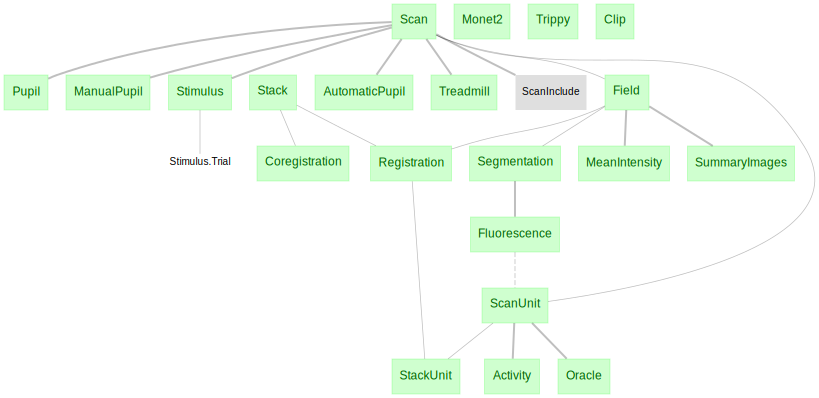

In [4]:
nda.schema.spawn_missing_classes() # may be necessary if next line gives error

dj.ERD(nda) # View schema ERD

## Basic DataJoint tutorial and data introduction

This tutorial will focus on basic DataJoint usage and introduce the functional data in the schema. 

For detailed information on the contents of the schema, please see our technical documentation [PDF](https://bossdb-open-data.s3.amazonaws.com/microns/minnie/functional-data/functional_data_technical_documentation_v1.pdf). 



### Scan table

Information from the completed scans are located in `nda.Scan`. Access the table by calling:

In [5]:
nda.Scan()

session Session ID,scan_idx Scan ID,filename Scan base filename uploaded to S3,nframes frames recorded,nfields number of fields,fps frames per second (Hz)
4,7,17797_4_00007,40000,8,6.3009
4,9,17797_4_00009,35112,8,6.3009
4,10,17797_4_00010,40000,8,6.3009
5,3,17797_5_00003,40000,8,6.3009
5,6,17797_5_00006,40000,8,6.3009
5,7,17797_5_00007,40000,8,6.3009
6,2,17797_6_00002,40000,8,6.3009
6,4,17797_6_00004,40000,8,6.3009
6,6,17797_6_00006,40000,8,6.3009
6,7,17797_6_00007,40000,8,6.3009


### Primary keys

[Primary](https://docs.datajoint.io/python/definition/07-Primary-Key.html?) keys are a subset of its attributes that uniquely identify each entity in the table.

In [6]:
[*nda.Scan.heading.primary_key] # primary keys 

['session', 'scan_idx']

### Restrict to a single scan

Dictionaries serve as keys for restricting table entries. The `session` attribute is the ID indicating the imaging period for the mouse. `scan_idx` is the index of the scan within the imaging session.

In [7]:
scan_key = {'session': 4, 'scan_idx': 7} 

In [8]:
nda.Scan & scan_key

session Session ID,scan_idx Scan ID,filename Scan base filename uploaded to S3,nframes frames recorded,nfields number of fields,fps frames per second (Hz)
4,7,17797_4_00007,40000,8,6.3009


### Restrict to a couple of scans

Use a list of dictionaries to restrict to multiple entries.

In [9]:
scan_keys = [{'session': 4, 'scan_idx': 7}, {'session': 5, 'scan_idx': 3}]

In [10]:
nda.Scan & scan_keys

session Session ID,scan_idx Scan ID,filename Scan base filename uploaded to S3,nframes frames recorded,nfields number of fields,fps frames per second (Hz)
4,7,17797_4_00007,40000,8,6.3009
5,3,17797_5_00003,40000,8,6.3009


### Fetch some information from a single scan

The [Fetch](https://docs.datajoint.io/python/queries/03-Fetch.html) methods allow for retrieval of the data within the tables. Use the `fetch1` method to retrieve the contents of the table for a single row. It will error if the restriction yields more than one row. 

In [11]:
nframes, nfields = (nda.Scan & scan_key).fetch1('nframes', 'nfields')
print(f'number of frames in this scan: {nframes}, number of imaging fields in this scan: {nfields}')

number of frames in this scan: 40000, number of imaging fields in this scan: 8


### Fetch some information from a couple of scans

Use `fetch` if the restriction yields more than one row. It will return a list for each attribute that is fetched. To fetch all attributes, do not pass any attributes to the `fetch` method

In [12]:
nframes, nfields = (nda.Scan & scan_keys).fetch('nframes', 'nfields')
print(f'number of frames in these scans: {nframes}, number of fields in these scans: {nfields}')

number of frames in these scans: [40000 40000], number of fields in these scans: [8 8]


### Fetch scans keys

Pass in `'KEY'` to `fetch` or `fetch1` to retrieve a list of dictionary keys.

In [13]:
nda.Scan.fetch('KEY')

[{'session': 4, 'scan_idx': 7},
 {'session': 4, 'scan_idx': 9},
 {'session': 4, 'scan_idx': 10},
 {'session': 5, 'scan_idx': 3},
 {'session': 5, 'scan_idx': 6},
 {'session': 5, 'scan_idx': 7},
 {'session': 6, 'scan_idx': 2},
 {'session': 6, 'scan_idx': 4},
 {'session': 6, 'scan_idx': 6},
 {'session': 6, 'scan_idx': 7},
 {'session': 7, 'scan_idx': 3},
 {'session': 7, 'scan_idx': 4},
 {'session': 7, 'scan_idx': 5},
 {'session': 8, 'scan_idx': 5},
 {'session': 8, 'scan_idx': 7},
 {'session': 8, 'scan_idx': 9},
 {'session': 9, 'scan_idx': 3},
 {'session': 9, 'scan_idx': 4},
 {'session': 9, 'scan_idx': 6}]

Fetch a single key.

In [14]:
(nda.Scan & scan_key).fetch1('KEY')

{'session': 4, 'scan_idx': 7}

### Included Scans

Scans designated for inclusion into analysis are found in `nda.ScanInclude`. Restrict against `nda.Scan` to apply.

In [15]:
nda.Scan & nda.ScanInclude

session Session ID,scan_idx Scan ID,filename Scan base filename uploaded to S3,nframes frames recorded,nfields number of fields,fps frames per second (Hz)
4,7,17797_4_00007,40000,8,6.3009
5,6,17797_5_00006,40000,8,6.3009
5,7,17797_5_00007,40000,8,6.3009
6,2,17797_6_00002,40000,8,6.3009
6,4,17797_6_00004,40000,8,6.3009
6,6,17797_6_00006,40000,8,6.3009
6,7,17797_6_00007,40000,8,6.3009
7,3,17797_7_00003,40000,8,6.3009
7,4,17797_7_00004,40000,8,6.3009
7,5,17797_7_00005,40000,8,6.3009


### Pupil and Treadmill

The pupil radius for each scan is found in `nda.ManualPupil`. `pupil_min_r` is the smaller of the two radii from the ellipse fit to the pupil and `pupil_maj_r` is the larger radius. The tracked position of the pupil is found in `pupil_x` and `pupil_y`. 

In [16]:
nda.ManualPupil & scan_key

session Session ID,scan_idx Scan ID,pupil_min_r vector of pupil minor radii synchronized with field 1 frame times (pixels),pupil_maj_r vector of pupil major radii synchronized with field 1 frame times (pixels),pupil_x vector of pupil x positions synchronized with field 1 frame times (pixels),pupil_y vector of pupil y positions synchronized with field 1 frame times (pixels)
4,7,=BLOB=,=BLOB=,=BLOB=,=BLOB=


The treadmill velocity for each scan is found in `nda.Treadmill`.

In [17]:
nda.Treadmill & scan_key

session Session ID,scan_idx Scan ID,treadmill_speed vector of treadmill velocities synchronized with field 1 frame times (cm/s)
4,7,=BLOB=


### Stimulus

The movie shown to the mouse for each scan is housed in `nda.Stimulus`

In [18]:
nda.Stimulus & scan_key

session Session ID,scan_idx Scan ID,movie stimulus images synchronized with field 1 frame times (H x W x T matrix)
4,7,=BLOB=


A trial represents a short segment of the stimulus. Trial information is logged in `nda.Stimulus.Trial` and indexed by `trial_idx`. 

There are three types of trials: `Clip`, `Monet2`, and `Trippy`. `Clip` types contain high-entropy scenes such as Hollywood clips, sports clips and rendered movies. `Monet2` and `Trippy` are parametric stimuli that are described in our accompanying methods. 

`start_idx` and `stop_idx` are the indices of the movie in `nda.Stimulus` during which the trial was ongoing. 

Each unique trial has an identifier in its `condition_hash`.

In [19]:
nda.Stimulus.Trial & scan_key

session Session ID,scan_idx Scan ID,trial_idx index of trial within stimulus,type type of stimulus trial,start_idx start frame of trial,end_idx end frame of trial,condition_hash 120-bit hash (The first 20 chars of MD5 in base64)
4,7,0,stimulus.Clip,55,118,JEL5/i5FccX4ykUOKaDW
4,7,1,stimulus.Clip,119,182,AAQ1HNKGrg1cIXlMw7nz
4,7,2,stimulus.Clip,182,245,ksTS42zV+O0YJqa0+s4Y
4,7,3,stimulus.Clip,246,308,m5JLObtSRnbRKw1ukcSE
4,7,4,stimulus.Clip,309,372,L8Z/mji+v1WipuJe4GaL
4,7,5,stimulus.Clip,372,435,3+VHi96yg36hu1kI8ZBn
4,7,6,stimulus.Monet2,436,530,DKYV7TrfEl+C8nvadH+1
4,7,7,stimulus.Monet2,531,625,+rgSVBVRE8Ij1WNhq8ZW
4,7,8,stimulus.Monet2,626,720,GHn0W57E+2PS+Qr5yD2r
4,7,9,stimulus.Monet2,721,815,u0ftbdrw9UHzSHDe1o4f


Detailed information about the stimulus during each trial can be obtained by restricting into the appropriate type-specific table. The example trial_key below restricts to a `Monet2` type trial. 

In [20]:
trial_key = {'session': 4, 'scan_idx': 7, 'trial_idx': 8}

In [21]:
trial_info = nda.Stimulus.Trial & trial_key
trial_info

session Session ID,scan_idx Scan ID,trial_idx index of trial within stimulus,type type of stimulus trial,start_idx start frame of trial,end_idx end frame of trial,condition_hash 120-bit hash (The first 20 chars of MD5 in base64)
4,7,8,stimulus.Monet2,626,720,GHn0W57E+2PS+Qr5yD2r


[Join](https://docs.datajoint.io/python/queries/07-Join.html) `trial_info` with `nda.Monet2` using the `*` operator to get all available information about the stimulus during that trial. 

`Monet2` is a directional stimuli, and the vector of directions during the trial is stored in the `directions` attribute. See technical methods for a more detailed description of the contents of this and other stimulus type tables. 

In [22]:
trial_info * nda.Monet2

session Session ID,scan_idx Scan ID,trial_idx index of trial within stimulus,condition_hash 120-bit hash (The first 20 chars of MD5 in base64),type type of stimulus trial,start_idx start frame of trial,end_idx end frame of trial,fps display refresh rate,duration (s) trial duration,rng_seed random number generator seed,"blue_green_saturation 0 = grayscale, 1=blue/green",pattern_width pixel size of the resulting pattern,pattern_aspect the aspect ratio of the pattern,temp_kernel,temp_bandwidth (Hz) temporal bandwidth of the stimulus,ori_coherence 1=unoriented noise. pi/ori_coherence = bandwidth of orientations.,ori_fraction fraction of time coherent orientation is on,ori_mix mixin-coefficient of orientation biased noise,n_dirs number of directions,speed (units/s) where unit is display width,directions computed directions of motion in degrees,onsets (s) computed,movie (computed) uint8 movie
4,7,8,GHn0W57E+2PS+Qr5yD2r,stimulus.Monet2,626,720,60.000,15.000,8.0,0.000,72,1.7,hamming,4.00,2.50,1.0,1.0,16,0.2,=BLOB=,=BLOB=,=BLOB=


Use `start_idx` and `end_idx` to view the part of the stimulus corresponding to the trial.

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns;

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [24]:
movie = (nda.Stimulus & scan_key).fetch1('movie') # Fetch movie
movie.shape

(40000, 90, 160)

In [25]:
start, end = (trial_info * nda.Monet2).fetch1('start_idx', 'end_idx') # Fetch indices of trial
print(f'Trial starts at index: {start} and ends at index {end}')

Trial starts at index: 626 and ends at index 720


In [26]:
stimulus_trial_slice = movie[slice(start, end)] # slice movie according to indices of trial
stimulus_trial_slice.shape

(94, 90, 160)

[(-0.5, 159.5, 89.5, -0.5), (-0.5, 159.5, 89.5, -0.5)]

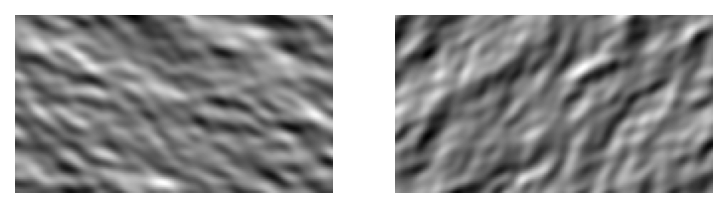

In [27]:
fig, axs = plt.subplots(1, 2, dpi=150) # view first and last frame of movie slice
axs[0].imshow(stimulus_trial_slice[0], cmap='gray')
axs[1].imshow(stimulus_trial_slice[-1], cmap='gray')
[ax.axis('off') for ax in axs]

### Field information

Each scan (identified by `session` and `scan_idx`) can have multiple imaging fields. These fields are indexed by the `field` attribute. `nda.Field` containes information for all imaging fields available for a scan.

In [28]:
nda.Field & scan_key

session Session ID,scan_idx Scan ID,field Field Number,px_width field pixels per line,px_height lines per field,um_width field width (microns),um_height field height (microns),field_x field x from registration into stack (microns),field_y field y from registration into stack (microns),field_z field z from registration into stack (microns)
4,7,1,248,440,620.0,1100.0,-485.0,-235.0,80.0
4,7,2,248,440,620.0,1100.0,95.0,-235.0,80.0
4,7,3,248,440,620.0,1100.0,-485.0,-235.0,220.0
4,7,4,248,440,620.0,1100.0,95.0,-235.0,220.0
4,7,5,248,440,620.0,1100.0,-485.0,-235.0,360.0
4,7,6,248,440,620.0,1100.0,95.0,-235.0,360.0
4,7,7,248,440,620.0,1100.0,-485.0,-235.0,500.0
4,7,8,248,440,620.0,1100.0,95.0,-235.0,500.0


Use a `field_key` to restrict to a single entry.

In [29]:
field_key = {'session': 4, 'scan_idx': 7, 'field': 4}

In [30]:
nda.Field & field_key

session Session ID,scan_idx Scan ID,field Field Number,px_width field pixels per line,px_height lines per field,um_width field width (microns),um_height field height (microns),field_x field x from registration into stack (microns),field_y field y from registration into stack (microns),field_z field z from registration into stack (microns)
4,7,4,248,440,620.0,1100.0,95.0,-235.0,220.0


### Summary image

A summary image of the field can be found in `nda.SummaryImages`. 

There are three types of images available, `correlation`, `l6norm`, and `average`. Details of how these are computed can be found in the accompanying methods.

In [31]:
nda.SummaryImages() & field_key

session Session ID,scan_idx Scan ID,field Field Number,correlation,l6norm,average
4,7,4,=BLOB=,=BLOB=,=BLOB=


#### Fetch and view images

In [32]:
corr, l6, avg = (nda.SummaryImages() & field_key).fetch1('correlation', 'l6norm', 'average')

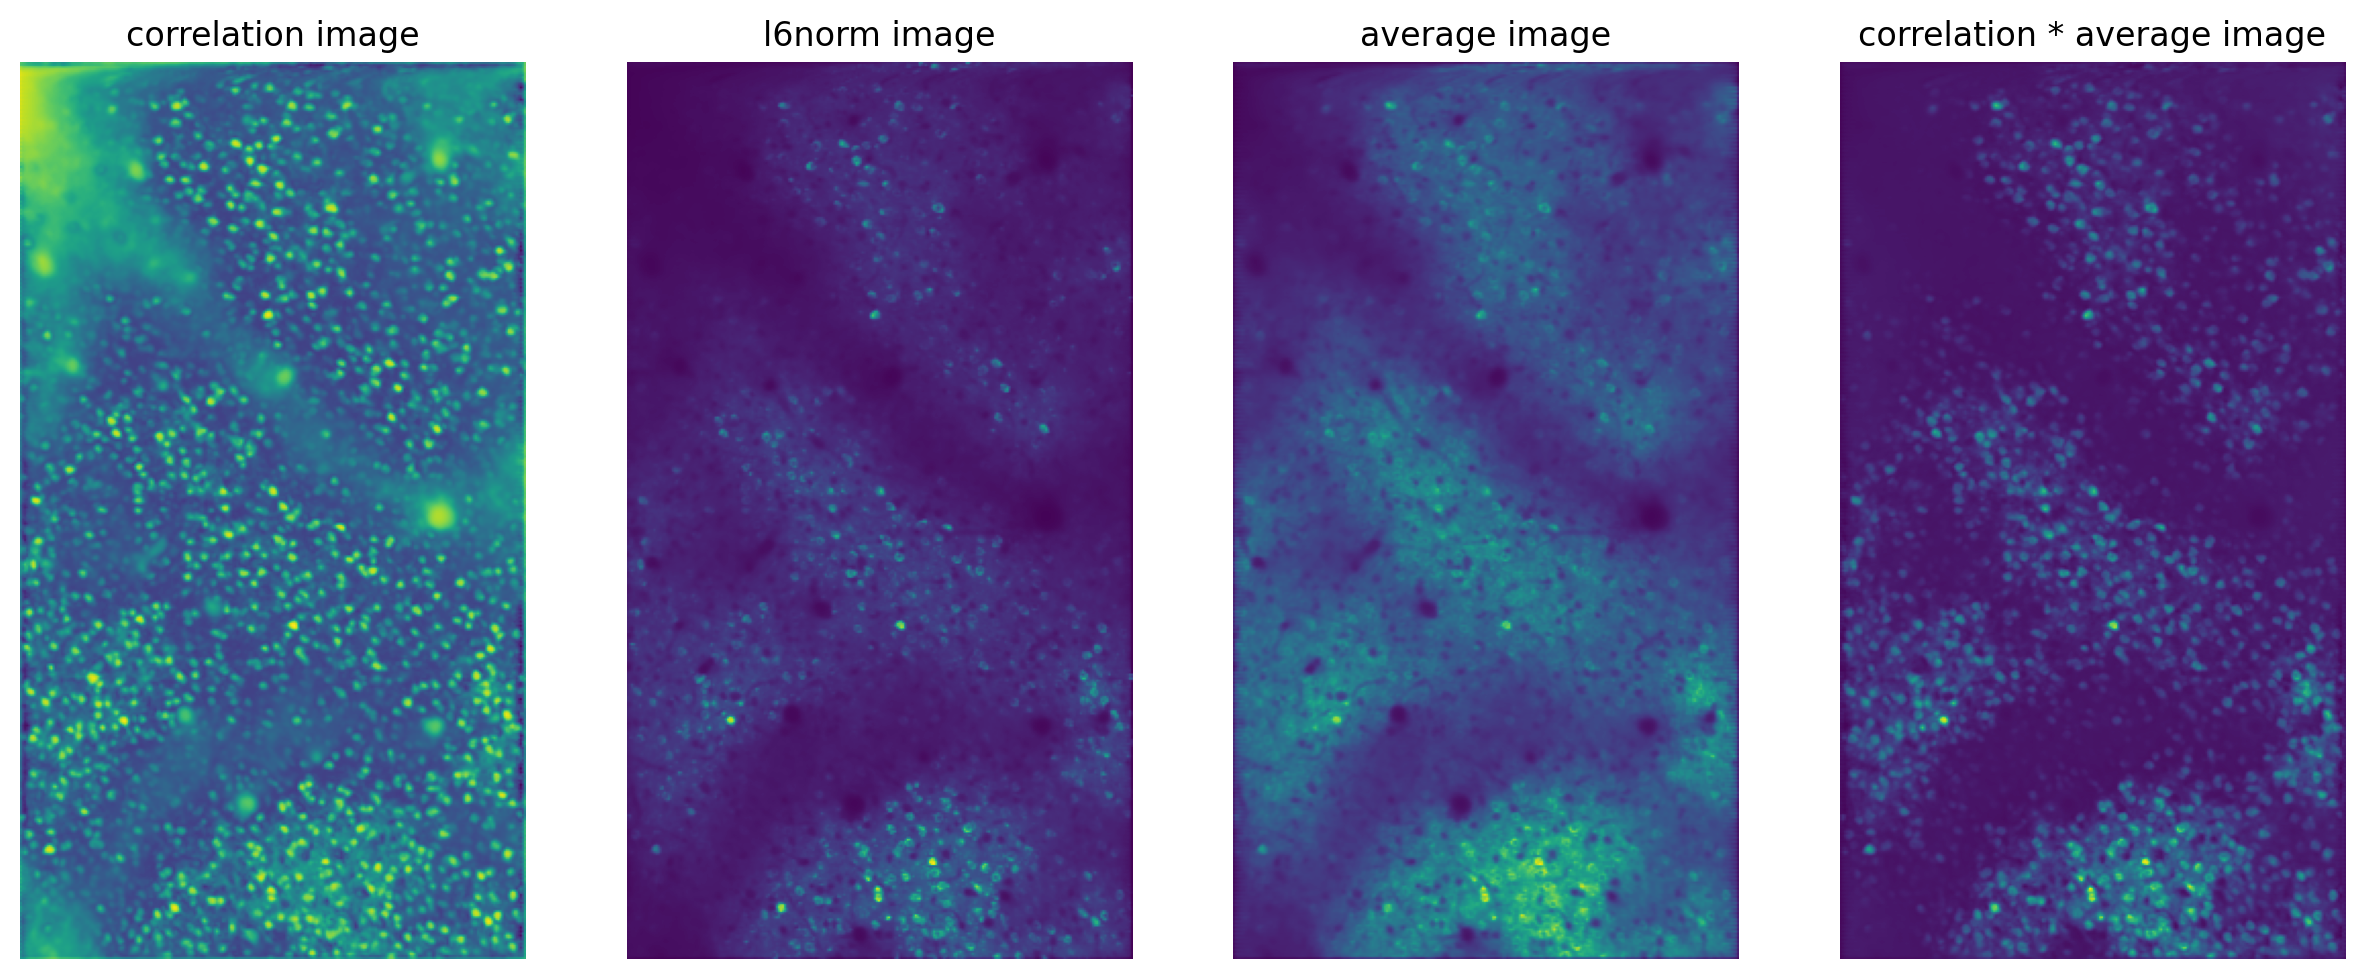

In [33]:
fig, axs = plt.subplots(1, 4, figsize=(15,6), dpi=200)
axs[0].imshow(corr)
axs[0].set_title('correlation image')
axs[1].imshow(l6)
axs[1].set_title('l6norm image')
axs[2].imshow(avg)
axs[2].set_title('average image')
axs[3].imshow(corr*avg) # gives a good view of the cell bodies and darkens vessels
axs[3].set_title('correlation * average image')
[ax.axis('off') for ax in axs];

### Mean Intensity

The mean intensity of the calcium signal for the entire field is computed per frame for the duration of the scan. This is found in `nda.MeanIntensity`. Periods of low intensity may indicate a low quality stretch of scan, for example where water might have temporarily run out between the microscope objective and imaging site.

In [34]:
intensities = (nda.MeanIntensity & field_key).fetch1('intensities')

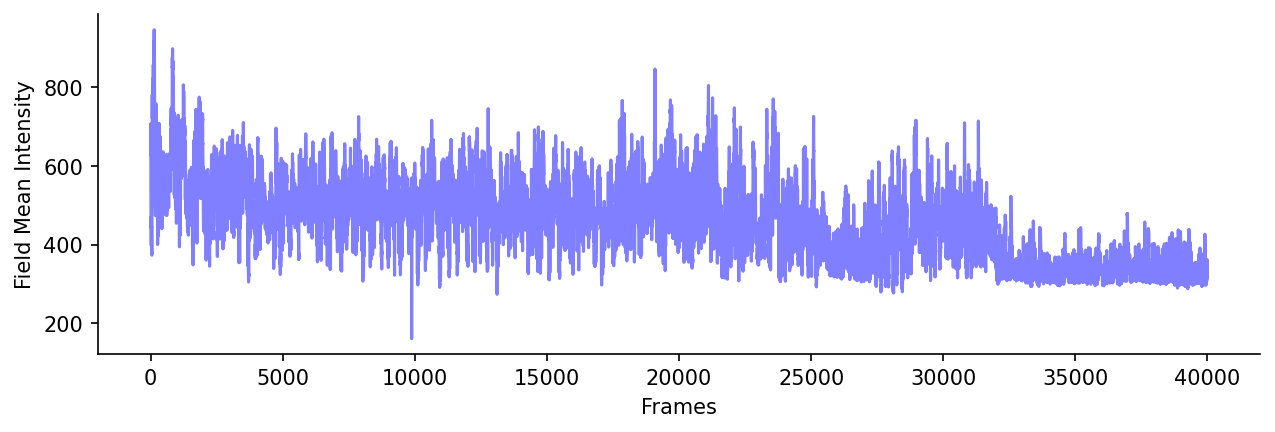

In [35]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(intensities, c='b', alpha=0.5)
ax.set_xlabel('Frames')
ax.set_ylabel('Field Mean Intensity')
sns.despine()

### Masks

The functional ROI segmentation gives a set of 2D masks indexed by `mask_id`, which are unique per `field`. A cell that was scanned in more than one imaging field will have more than one mask.

In [36]:
nda.Segmentation & field_key

session Session ID,scan_idx Scan ID,field Field Number,mask_id,pixels indices into the image in column major (Fortran) order,weights weights of the mask at the indices above
4,7,4,1,=BLOB=,=BLOB=
4,7,4,2,=BLOB=,=BLOB=
4,7,4,3,=BLOB=,=BLOB=
4,7,4,4,=BLOB=,=BLOB=
4,7,4,5,=BLOB=,=BLOB=
4,7,4,6,=BLOB=,=BLOB=
4,7,4,7,=BLOB=,=BLOB=
4,7,4,8,=BLOB=,=BLOB=
4,7,4,9,=BLOB=,=BLOB=
4,7,4,10,=BLOB=,=BLOB=


Fetch masks and plot over the summary image to view them.

In [37]:
import numpy as np

In [38]:
masks = func.get_all_masks(field_key) # function that will retrieve masks in convenient format

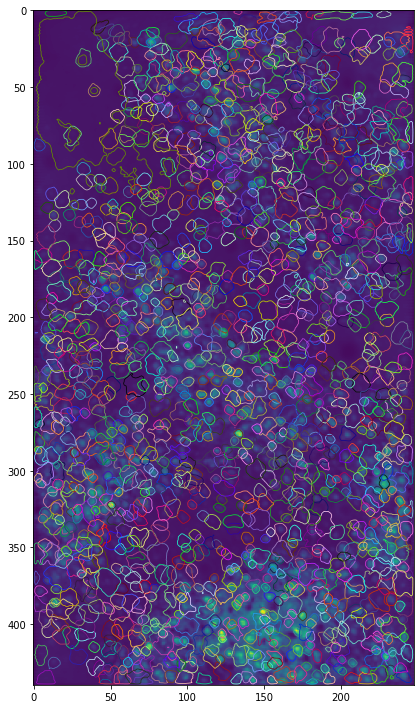

In [39]:
image_height, image_width, num_masks = masks.shape
figsize = np.array([image_width, image_height]) / min(image_height, image_width)
fig = plt.figure(figsize=figsize * 7)
plt.imshow(corr*avg)

cumsum_mask = np.empty([image_height, image_width])
for i in range(num_masks):
    mask = masks[:, :, i]

    ## Compute cumulative mass (similar to caiman)
    indices = np.unravel_index(
        np.flip(np.argsort(mask, axis=None), axis=0), mask.shape
    )  # max to min value in mask
    cumsum_mask[indices] = np.cumsum(mask[indices] ** 2) / np.sum(mask ** 2)

    ## Plot contour at desired threshold (with random color)
    random_color = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.contour(cumsum_mask, [0.97], linewidths=0.8, colors=[random_color])

### Calcium fluorescence traces

Each mask has a GCaMP6 fluorescence trace in `nda.Fluorescence`.

In [40]:
calcium_trace = (nda.Fluorescence() & field_key & {'mask_id': 500}).fetch1('trace')

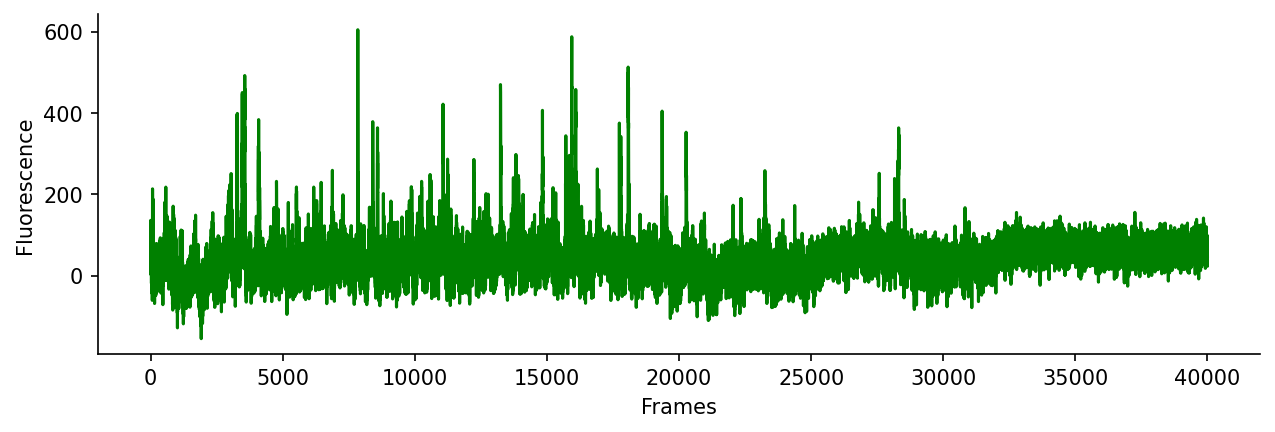

In [41]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(calcium_trace, c='g')
ax.set_xlabel('Frames')
ax.set_ylabel('Fluorescence')
sns.despine()

### Single unit information

For the purposes of this schema, a `unit` is a re-indexing of all masks across all imaging fields of a scan and indexed by `unit_id`. `unit_id` is unique per scan.

Note: `unit_id` is not a consolidation step, only re-indexing. Therefore, if a cell was scanned in multiple imaging fields within the scan, just as it had multiple `mask_id's`, it will have multiple `unit_id's`. 

Information for all units in the scan can be found in `nda.ScanUnit`. This table can be used to relate `mask_id` to its `unit_id`.  

In [42]:
# unit coordinates (`um_x`, `um_y`, `um_z`) are in microns and in the original motor reference frame (see technical documentation for more info)
# unit coordinate (`px_x` and `px_y` are the unit coordinates in image pixels)
# this table can also be used to relate `unit_id's` and `mask_id's` that are used in nda.Segmentation and nda.Fluorescence
nda.ScanUnit() & scan_key

session Session ID,scan_idx Scan ID,unit_id unique per scan,field Field Number,mask_id,um_x x-coordinate of centroid in motor coordinate system,um_y y-coordinate of centroid in motor coordinate system,um_z z-coordinate of mask relative to surface of the cortex,px_x x-coordinate of centroid in the frame,px_y y-coordinate of centroid in the frame,ms_delay (ms) delay from start of frame to recording of this unit
4,7,1,1,1,-778,-771,80,7,5,0
4,7,2,1,2,-741,-766,80,22,7,0
4,7,3,1,3,-691,-776,80,41,3,0
4,7,4,1,4,-691,-766,80,42,8,0
4,7,5,1,5,-702,-767,80,37,7,0
4,7,6,1,6,-646,-764,80,60,8,0
4,7,7,1,7,-553,-770,80,97,6,0
4,7,8,1,8,-534,-758,80,105,11,0
4,7,9,1,9,-499,-760,80,119,10,0
4,7,10,1,10,-460,-768,80,134,7,0


### Oracle score 

The oracle score is a leave-one-out correlation for repeated segments of stimulus. It provides an estimate of visual response reliability for a given unit over the course of the scan. For more detail see technical methods.

Oracle scores are found in `nda.Oracle`. 

In [43]:
oracles = (nda.Oracle & scan_key).fetch('pearson')

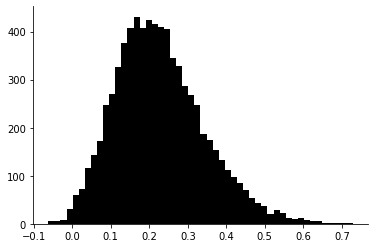

In [44]:
fig, ax = plt.subplots()
ax.hist(oracles, bins=50, color='k');
sns.despine()

In [45]:
high_oracle_percentile = np.percentile(oracles, 99)

Oracle scores greater than a threshold value can be specified by restricting the table with a string: `'pearson>x'` where `x` is the oracle value threshold.

In [46]:
high_oracle_table = nda.Oracle & scan_key & f'pearson>{high_oracle_percentile}'
high_oracle_table

session Session ID,scan_idx Scan ID,unit_id unique per scan,trials number of trials used,pearson per unit oracle pearson correlation over all movies
4,7,130,60,0.623745
4,7,327,60,0.61131
4,7,493,60,0.54457
4,7,688,60,0.561252
4,7,756,60,0.617953
4,7,775,60,0.638734
4,7,795,60,0.613519
4,7,907,60,0.574646
4,7,1070,60,0.553697
4,7,1177,60,0.57389


Select the key for the first entry in the table by passing a `limit` to the `fetch` method.

In [47]:
unit_key = high_oracle_table.fetch('KEY', limit=1)[0]

### Spike traces

Spike traces are in `nda.Activity` and associated with single units (`unit_id's`).

In [48]:
spike_trace = (nda.Activity() & unit_key).fetch1('trace')

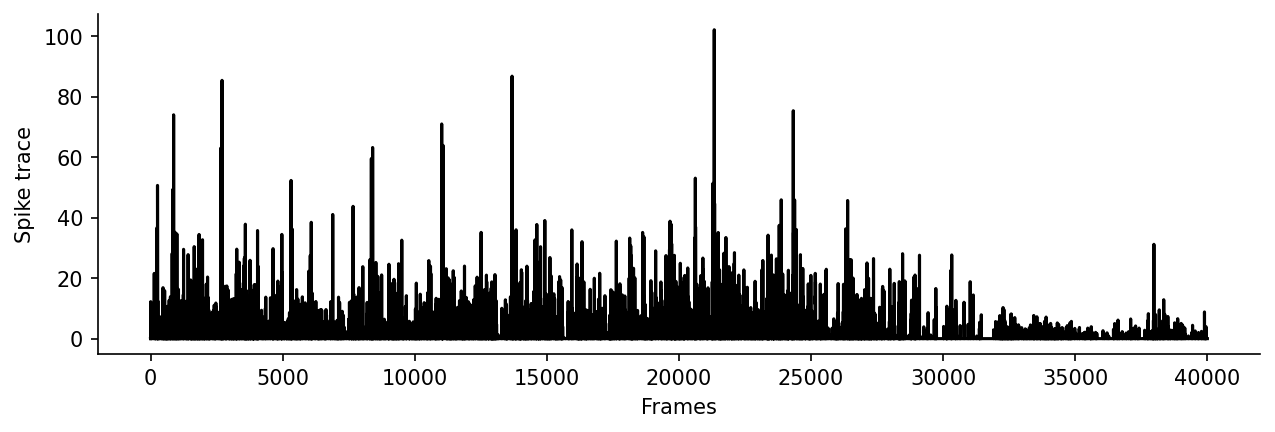

In [49]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(spike_trace, c='k')
ax.set_xlabel('Frames')
ax.set_ylabel('Spike trace')
sns.despine()

### View  fluorescence trace, and spike trace for the same unit

Use `nda.ScanUnit` to bridge between `unit_id` and `mask_id` to plot both the calcium trace spike trace and for a single unit.

In [50]:
calcium_trace = (nda.Fluorescence & (nda.ScanUnit & unit_key)).fetch1('trace')

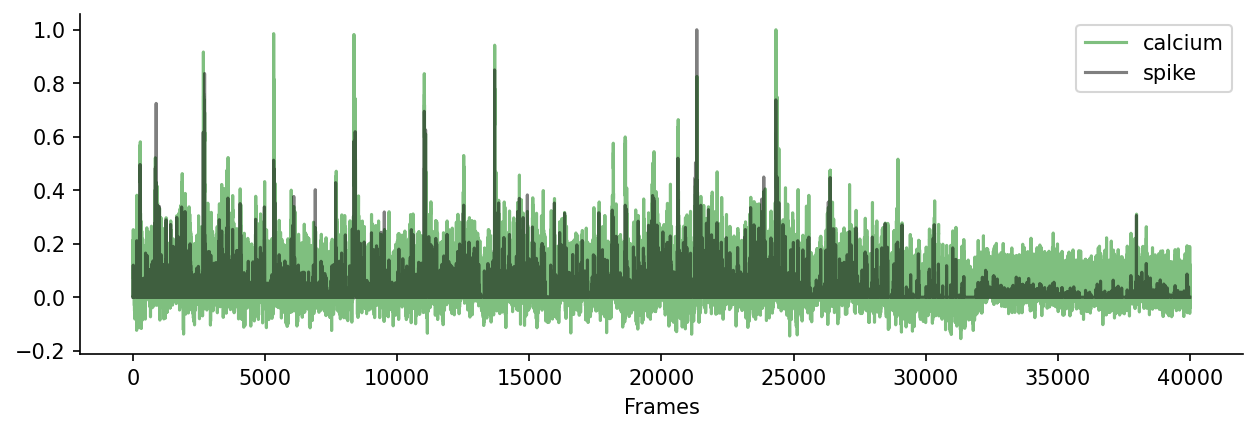

In [51]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(calcium_trace/ np.max(calcium_trace), c='g', alpha=0.5, label='calcium')
ax.plot(spike_trace/ np.max(spike_trace), c='k', label='spike', alpha=0.5)
ax.set_xlabel('Frames')
ax.legend()
sns.despine()

### Plot tuning curve

The function `concatenate_monet2` in the `func` module retrieve the directional trials and responses for the functional unit from the Monet2 stimulus type and the function `von_mises_pdf` fits a Von Mises curve to the data. The individual trial response means and von mises curve are plotted below.

In [52]:
indices, directions, responses = func.concatenate_monet2(unit_key) # fetch Monet2 stimulus directions and responses for specified functional unit

In [53]:
x_pdf, pdf = func.von_mises_pdf(directions, responses) # compute von mises probability density function

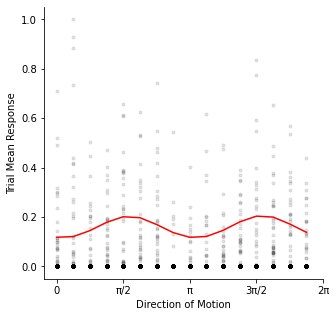

In [54]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(directions, responses/np.max(responses), '.k', alpha=0.1)
ax.plot(x_pdf, pdf, 'r')
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax.set_xticklabels(['0', '\u03C0/2', '\u03C0', '3\u03C0/2', '2\u03C0'])
ax.set_ylabel('Trial Mean Response')
ax.set_xlabel('Direction of Motion')
sns.despine()
plt.show()
plt.close()

## Field to Stack registration

A high spatial resolution structural 2P-Stack was acquired to serve as a common reference frame between the 2P functional imaging planes and the EM volume. Each imaging field was registered into the stack using affine registration learned via gradient ascent. For more detail see technical methods. 

### Stack information

The information on the structural 2P stack can be found in `nda.Stack`. 

In [55]:
nda.Stack()

stack_session session index for the mouse,stack_idx id of the stack,z (um) center of volume in the motor coordinate system (cortex is at 0),y (um) center of volume in the motor coordinate system,x (um) center of volume in the motor coordinate system,px_depth number of slices,px_height lines per frame,px_width pixels per line,um_depth depth in microns,um_height height in microns,um_width width in microns,surf_z (um) depth of first slice - half a z step (cortex is at z=0)
9,19,314.0,-173.688,-236.91,335,661,706,670.0,1322.0,1412.0,-21.0


The affine matrix resulting from registration of each imaging field into the stack is located in `nda.Registration`. The attribute `reg_field` is the extracted stack image corresponding to the field grid after registration. In a good registration, the functional summary image in `nda.SummaryImages` and `reg_field` will be very similar. 

### Field registration

In [56]:
# affine matrix parameters for each field registered into the stack
nda.Registration() & field_key

stack_session session index for the mouse,stack_idx id of the stack,session Session ID,scan_idx Scan ID,field Field Number,"a11 (um) element in row 1, column 1 of the affine matrix","a21 (um) element in row 2, column 1 of the affine matrix","a31 (um) element in row 3, column 1 of the affine matrix","a12 (um) element in row 1, column 2 of the affine matrix","a22 (um) element in row 2, column 2 of the affine matrix","a32 (um) element in row 3, column 2 of the affine matrix","reg_x (um) element in row 1, column 4 of the affine matrix","reg_y (um) element in row 2, column 4 of the affine matrix","reg_z (um) element in row 3, column 4 of the affine matrix",score cross-correlation score (-1 to 1),reg_field extracted field from the stack in the specified position
9,19,4,7,4,1.00784,-0.00337667,-0.017749,-0.0231734,0.994399,0.00351191,94.7115,-276.434,217.736,0.646221,=BLOB=


In [57]:
reg_field = (nda.Registration() & field_key).fetch1('reg_field')

The functional summary image and registered stack field image are plotted for visual comparison. 

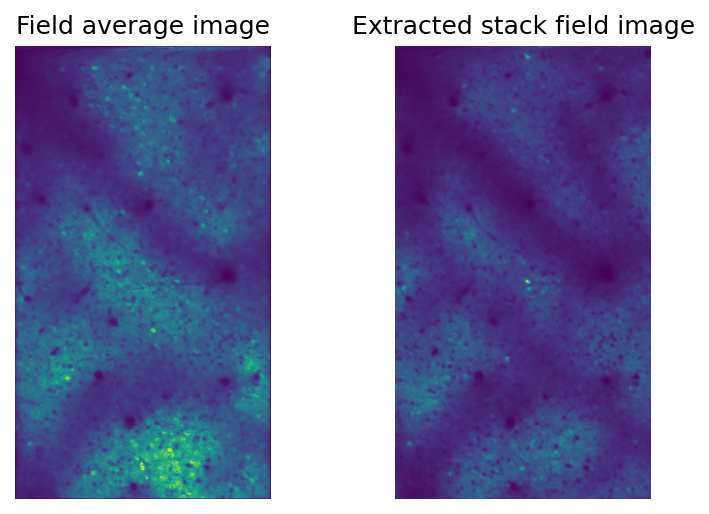

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(6,4), dpi=150)
axs[0].imshow(avg)
axs[0].set_title('Field average image')
axs[1].imshow(reg_field)
axs[1].set_title('Extracted stack field image')
[ax.axis('off') for ax in axs];

# WORK IN PROGRESS BELOW

### Field grid after stack registration

In [59]:
grid = func.get_grid(field_key) # fetch registered grid 

stack_x, stack_y, stack_z = nda.Stack.fetch1('x', 'y', 'z') # get stack center

grid = grid - np.array([stack_x, stack_y, stack_z]) # subtract stack center from grid

grid.shape

(1100, 620, 3)

### get field grid in EM coordinates

In [60]:
# transform_id 1 - 4 phase2 transforms # these transforms are deprecated 
# transform_id 5 - 8 phase3 transforms
# transform_id 1, 3, 5, 7 go from 2P --> EM
# transform_id 2, 4, 6, 8 go from EM --> 2P
# transform_type "spline" is more accurate but is slower. Recommend using "spline" whenever possible
# transform_type "linear" is a modified version of spline with less non-linearity and is faster to run
nda.Coregistration()

stack_session session index for the mouse,stack_idx id of the stack,transform_id id of the transform,version coordinate framework,"direction direction of the transform (EMTP: EM -> 2P, TPEM: 2P -> EM)",transform_type linear (more rigid) or spline (more nonrigid),transform_args parameters of the transform,transform_solution transform solution
9,19,1,phase2,2PEM,spline,=BLOB=,=BLOB=
9,19,2,phase2,EM2P,spline,=BLOB=,=BLOB=
9,19,3,phase2,2PEM,linear,=BLOB=,=BLOB=
9,19,4,phase2,EM2P,linear,=BLOB=,=BLOB=
9,19,5,phase3,2PEM,spline,=BLOB=,=BLOB=
9,19,6,phase3,EM2P,spline,=BLOB=,=BLOB=
9,19,7,phase3,2PEM,linear,=BLOB=,=BLOB=
9,19,8,phase3,EM2P,linear,=BLOB=,=BLOB=


In [61]:
# fetch coregistration
# transform_params = func.fetch_coreg(transform_id=5) # phase3 "spline" transform
# transform_params = func.fetch_coreg(transform_id=7) # phase3 "linear" transform

In [62]:
# fetch grid in EM coordinates
# em_grid = func.field_to_EM_grid(field_key, **transform_params)
# em_grid.shape

(1100, 620, 3)

In [63]:
# alternatively transform_id can be passed directly to field_to_EM_grid and the coregistration will be fetched inside the function
# em_grid = func.field_to_EM_grid(field_key, transform_id=5)
# em_grid.shape

(1100, 620, 3)

In [65]:
# visualize field grid in Neuroglancer

# em_grid_annotations = utils.coordinate(em_grid[::25,::25]) # reshape grid to n x 3 and sparsely sample
# ng_link = utils.add_point_annotations(func.phase3_ng_link, 'grid', em_grid_annotations, voxelsize=[4, 4, 40], color='#f1ff00') # add grid points as annotations in Neuroglancer
# display(HTML(f'<a href="{ng_link}">Neuroglancer</a>'))

### transform cell coordinates from stack to EM coordinates

In [ ]:
# cell_xyz = np.stack((nda.StackUnit() & field_key).fetch('np_x', 'np_y', 'np_z'), -1) # fetch stack unit x, y, z in numpy reference frame

In [ ]:
# em_coords = func.coreg_transform(cell_xyz, transform_id=7)

In [ ]:
# ng_link = utils.add_point_annotations(func.phase3_ng_link, 'units', em_coords, voxelsize=[4, 4, 40], color='#f1ff00') # add unit coordinate as annotation in Neuroglancer
# display(HTML(f'<a href="{ng_link}">Neuroglancer</a>'))